# Forecasting using ARIMA type methods 
* Guides with codes on https://ranasinghiitkgp.medium.com/time-series-forecasting-using-lstm-arima-moving-average-use-case-single-multi-variate-with-code-5dd41e32d1fc
* Here we try out and compare different forecasting methods:
  * Moving average
  * Linear regression
  * K-nearest neighbours
  * ARIMA
    * Vanilla
    * Models from Olga's codes:
        * ARIMA with exogenous vars 
        * Vanill recursive ARIMA 
        * Recursive ARIMA with exogenous vars 
  * LSTM (long short term memory)
* We use data from 2019-Q1 to 2021-Q3
    * Compute the RMSE for each model on 2021-Q4 data (leave-the-latest-out validationn)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# install and import necessary packages 

!pip install geopandas rtree &> /dev/null 

import geopandas as gpd
import pandas as pd
import numpy as np
import rtree
import os
import pickle
import matplotlib.pyplot as plt

print(os.getcwd())

Mounted at /content/drive
/content


In [ ]:
## Load the source data
os.chdir('/content/drive/MyDrive/shared/ssc22-case-comp/dataset/')
with open('./cd-w-avg-with-dist.p', 'rb') as file:
  data = pickle.load(file)

data.head(5)

,PRUID,CDUID,avg_lat_ms,distance,SACTYPE,DA_POP,devices,tests,geometry,conn_type,time,avg_d_mbps,avg_u_mbps
0,61,6101.0,36.755102,6.425546,8.000000,448.265306,19.0,49.0,"MULTIPOLYGON (((4642490.038 4066985.206, 46426...",fixed,2019-Q1,14.574776,5.991551
1,61,6102.0,28.585366,444.526332,8.000000,747.073171,16.0,41.0,"MULTIPOLYGON (((4695765.369 3628102.680, 46958...",fixed,2019-Q1,26.693902,3.160341
2,61,6103.0,324.200000,104.673055,8.000000,330.000000,3.0,5.0,"MULTIPOLYGON (((5032382.179 3158440.088, 50322...",fixed,2019-Q1,11.964200,0.841000
3,61,6104.0,24.850000,306.145252,8.000000,739.250000,15.0,40.0,"MULTIPOLYGON (((4567677.409 3073390.226, 45678...",fixed,2019-Q1,9.468550,1.158050
4,61,6106.0,29.559838,9.110629,3.212982,630.091278,240.0,493.0,"MULTIPOLYGON (((5094536.880 3094447.671, 50944...",fixed,2019-Q1,52.260937,7.403355


In [ ]:
data.info()

NameError: ignored

         time  avg_d_mbps
79 2019-03-31  123.602751
76 2019-06-30  128.684551
79 2019-09-30  128.724268
84 2019-12-31  133.590714
83 2020-03-31  135.310426
82 2020-06-30  136.484269
82 2020-09-30  144.234757
79 2020-12-31  163.311257
79 2021-03-31  183.329588
77 2021-06-30  202.881035
78 2021-09-30  211.508482
79 2021-12-31  215.701498


Text(0.5, 1.0, 'download speed trend over time for CSD=4806016')

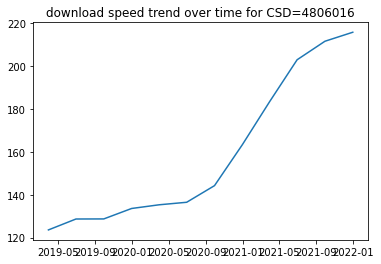

In [ ]:
## Take only one CSD as an example.

example_idx = (data['PRUID'] == '48') & (data['conn_type'] == 'fixed') & (data['CSDUID']=='4806016')
example_data = data[example_idx].sort_values(by='time')[['time', 'avg_d_mbps']]

print(example_data)

## Plot the true download speed
plot_x = example_data['time']
plot_y = example_data['avg_d_mbps']

plt.plot(plot_x, plot_y)
plt.title('download speed trend over time for CSD={csd}'.format(csd = 4806016))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


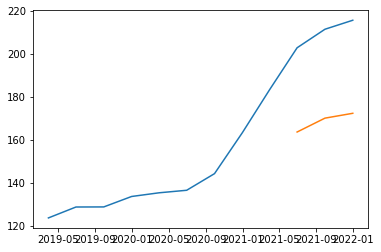

In [ ]:
## Moving averages

## create a subset that only contains avg_d_mbps and time

train_set = example_data.iloc[0:9] # the first 10 observations
val_set = example_data.iloc[-3:] # the last two observations

preds = []
for i in range(0,val_set.shape[0]):
    a = train_set['avg_d_mbps'][len(train_set)-len(val_set)+i:].sum() + sum(preds)
    b = a/len(val_set)
    preds.append(b)

pred_df = val_set
pred_df['pred'] = preds

pred_df
plt.plot(plot_x, plot_y)
plt.plot(pred_df['time'], pred_df['pred'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


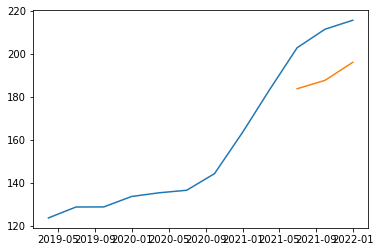

In [ ]:
## Linear regression

### Prepare data
data_lin = data[example_idx][['avg_d_mbps', 'tests','devices','time']] # take 4 features

### Make features? (like, make time a numerical variable?)
times = sorted(data_lin['time'].unique())
time_ints = [*range(1,len(times)+1)]
data_lin['time_int'] = data_lin['time'].replace(to_replace=times, value = time_ints)

### Split train, val data
lin_train_set = data_lin.iloc[0:-3]
lin_x_train = lin_train_set.drop(columns=['time', 'avg_d_mbps'])
lin_y_train = lin_train_set[['avg_d_mbps']]

lin_val_set = data_lin.iloc[-3:]
lin_x_valid = lin_val_set.drop(columns=['time', 'avg_d_mbps'])
lin_y_valid = lin_val_set[['avg_d_mbps']]

### Implement linear regression
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(lin_x_train, lin_y_train)

### make predictions
preds = model.predict(lin_x_valid)

pred_df = lin_val_set
pred_df['pred'] = preds

pred_df
plt.plot(plot_x, plot_y)
plt.plot(pred_df['time'], pred_df['pred'])

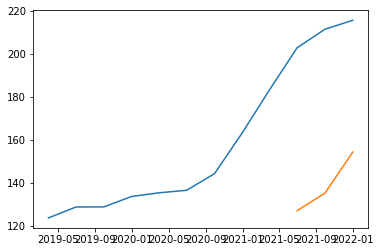

In [ ]:
## k-Nearest Neighbours
from sklearn import neighbors
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

# k_data = example_data
# k_x_train = example_data[:-3].drop(columns='avg_d_mbps')
# k_y_train = example_data[-3:].drop(columns='time')
k_data = data_lin.copy()
k_x_train = lin_x_train.copy()
k_y_train = lin_y_train.copy()
k_x_valid = lin_x_valid.copy()
k_y_valid = lin_y_valid.copy()

#scaling data
x_train_scaled = scaler.fit_transform(k_x_train)
x_tr_scaled_df = pd.DataFrame(x_train_scaled)
x_valid_scaled = scaler.fit_transform(k_x_valid)
x_val_scaled_df = pd.DataFrame(x_valid_scaled)

#using gridsearch to find the best parameter
params = {'n_neighbors':[2,3,4]}
knn = neighbors.KNeighborsRegressor()
model = GridSearchCV(knn, params, cv=4)

#fit the model and make predictions
model.fit(x_tr_scaled_df,k_y_train)
preds = model.predict(x_val_scaled_df)

pred_df = val_set.copy()
pred_df['pred'] = preds

pred_df
plt.plot(plot_x, plot_y)
plt.plot(pred_df['time'], pred_df['pred'])

/usr/local/lib/python3.7/dist-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=69.970, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=72.677, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=68.924, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=69.426, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=79.322, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=68.503, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=69.507, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=69.885, Time=0.03 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0] intercept
Total fit time: 0.697 seconds
         time  avg_d_mbps        pred
79 2021-12-31  215.701498  213.809157


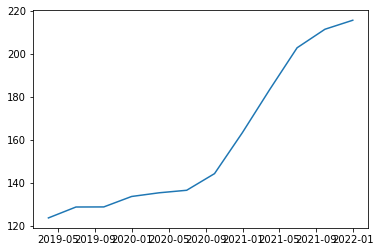

In [ ]:
## Auto ARIMA

!pip install pmdarima &> /dev/null

from pmdarima.arima import auto_arima

## prepare data
ar_data = example_data.copy()

ar_train = ar_data[:-1]
ar_x_train = ar_train[['time']]
ar_y_train = ar_train[['avg_d_mbps']]

ar_val = ar_data[-1:]
ar_x_val = ar_val[['time']]
ar_y_val = ar_val[['avg_d_mbps']]


# plug in some random parameter values
model = auto_arima(ar_y_train, 
                   start_p=1, 
                   start_q=1,
                   max_p=3, 
                   max_q=3, 
                   m=12,
                   start_P=0, 
                   seasonal=False,
                   d=1, 
                   D=0, 
                   trace=True,
                   error_action='ignore',
                   suppress_warnings=True
                   )
model.fit(ar_y_train)

forecast = model.predict(n_periods=1)
forecast = pd.DataFrame(forecast,index = ar_y_val.index,columns=['Prediction'])

pred_df = ar_val.copy()
pred_df['pred'] = forecast

print(pred_df)

plt.plot(plot_x, plot_y)
plt.plot(pred_df['time'], pred_df['pred'])

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 6.


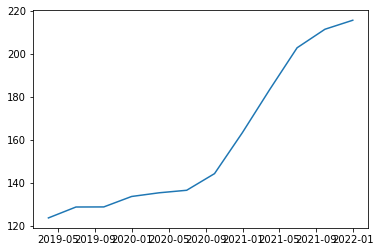

In [ ]:
## Facebook's Prophet

from fbprophet import Prophet

## The input for Prophet is a dataframe with two columns: date and target (ds and y).
## Prophet tries to capture the seasonality in the past data and works well when the dataset is large.


# #preparing data
ph_data = example_data.copy().rename(columns={'time': 'ds', 'avg_d_mbps':'y'})
ph_data.index = ph_data['ds']

ph_train = ph_data[:-3]
ph_val = ph_data[-3:]

# #fit the model
model = Prophet()
model.fit(ph_train)

#predictions
y_mod = model.make_future_dataframe(periods=len(ph_val))
ph_pred = model.predict(y_mod)

## plot
pred_df = val_set.copy()
pred_df['pred'] = ph_pred['yhat'][-3:]

plt.plot(plot_x, plot_y)
plt.plot(pred_df['time'], pred_df['pred'])


In [ ]:
x_train

array([[[0.        ],
        [0.05517773],
        [0.05560898]],

       [[0.05517773],
        [0.05560898],
        [0.10844841]],

       [[0.05560898],
        [0.10844841],
        [0.1271209 ]],

       [[0.10844841],
        [0.1271209 ],
        [0.13986637]],

       [[0.1271209 ],
        [0.13986637],
        [0.22402048]],

       [[0.13986637],
        [0.22402048],
        [0.43115142]]])

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"


avg_d_mbps    58.586417
dtype: float64
    avg_d_mbps  tests devices       time  time_int        pred
77  202.881035  88909   27287 2021-06-30        10  150.655090
78  211.508482  93164   30422 2021-09-30        11  151.714752
79  215.701498  90762   29765 2021-12-31        12  152.501297


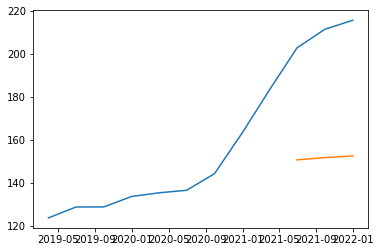

In [ ]:
## Long short term memory

# LSTM has three gates:
# The input gate: The input gate adds information to the cell state
# The forget gate: It removes the information that is no longer required by the model
# The output gate: Output Gate at LSTM selects the information to be shown as output

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

ex2 = example_data.copy()
ex2.index = ex2.time
ex2.drop('time', axis=1, inplace=True)
train = ex2[:-3]
valid = ex2[-3:]

#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(ex2)

x_train, y_train = [], []

for i in range(3,len(train)):
    x_train.append(scaled_data[i-3:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=3, 
               return_sequences=True, 
               input_shape=(x_train.shape[1],1))
)
model.add(LSTM(units=3))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=50, batch_size=1, verbose=0)

#predicting 3 values, using past 3 from the train data
inputs = ex2[len(ex2) - len(valid) - 3:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(3,inputs.shape[0]):
    X_test.append(inputs[i-3:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
pred_mod = model.predict(X_test)
pred = scaler.inverse_transform(pred_mod)

rms=np.sqrt(np.mean(np.power((valid-pred),2)))
print(rms)

pred_df = val_set.copy()
pred_df['pred'] = pred
print(pred_df)

plt.plot(plot_x, plot_y)
plt.plot(pred_df['time'], pred_df['pred'])

# does not perform well: may be due to limited data size.

In [ ]:
data['time1'] = data['time'].dt.strftime('%Y-%m')  ## convert datetime format to string since geopandas cannot take datetime format column.
data = data.drop(columns = ['time'])

data1 = data[(data['time1'] == '2019-03') & (data['conn_type']=='fixed')] ## extract the first time point as an experimental set.
data1.shape

## convert pandas to geopandas df
geo_data1 = gpd.GeoDataFrame(data1, geometry='geometry')
geo_data1 = geo_data1.set_crs(4326, allow_override=True)

geo_data1.plot()

(3649, 13)